In [25]:
import cv2
import matplotlib.pyplot as plt
import time
import torch
from PIL import Image
from IPython import display
%matplotlib inline

In [2]:
from models import *
from utils.utils import *
from utils.datasets import *

In [3]:
device = torch.device("cuda")

In [4]:
model = Darknet("./config/yolov3.cfg", img_size = 416).to(device)
model.load_darknet_weights("./weights/yolov3.weights")
model.eval()
print("use device", device)

use device cuda


In [48]:
def detect(img_path, img_size=416):
    display.clear_output()
    classes = load_classes("./coco.names")
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]
    
    img = transforms.ToTensor()(Image.open(img_path))
    # Pad to square resolution
    img, _ = pad_to_square(img, 0)
    # Resize
    img = resize(img, img_size)
    img = img.unsqueeze(0)
    input_imgs = Variable(img.type(torch.cuda.FloatTensor))
    with torch.no_grad():
        detections = model(input_imgs)
        detections = non_max_suppression(detections, 0.8, 0.4)
        
    img = np.array(Image.open(img_path))
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    if detections[0] is not None:
        # Rescale boxes to original image
        detections = detections[0]
        detections = rescale_boxes(detections, img_size, img.shape[:2])
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

            box_w = x2 - x1
            box_h = y2 - y1

            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            # Create a Rectangle patch
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
            # Add the bbox to the plot
            ax.add_patch(bbox)
            # Add label
            plt.text(
                x1,
                y1,
                s=classes[int(cls_pred)],
                color="white",
                verticalalignment="top",
                bbox={"color": color, "pad": 0},
            )
        display.clear_output(wait=True)
        display.display(plt.gcf())

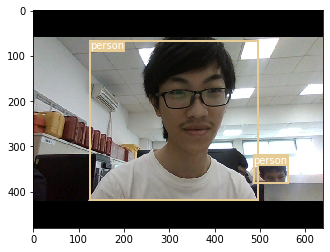

detect time： 0.7639884948730469
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000017EF3D17A68> (for post_execute):


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

Error in callback <function flush_figures at 0x0000017EF3D1FCA8> (for post_execute):


KeyboardInterrupt: 

In [49]:
cap = cv2.VideoCapture(0)
while(cap.isOpened()):
    try:
        ret, frame = cap.read()
        cv2.imwrite('./data/1.jpg', frame) 
        start_time = time.time()
        detect("./data/1.jpg")
        print("detect time：", time.time() - start_time)
        time.sleep(1)
    except KeyboardInterrupt:
        break
cap.release()